In [1]:
%load_ext autoreload
%autoreload 2

import time

import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import albumentations as A

from dataset import *

data_valid_p = Path('data/data_valid.json')
data_train_p = Path('data/data_train.json')

/home/tomas/miniconda3/envs/tomlynx/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.nn as nn
from torchvision.models import vgg11, VGG11_Weights

NUM_POINTS = 14

# define model
class Model1(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained = pretrained_model
        self.fc1 = nn.Linear(512*4*7, NUM_POINTS*2) # n*2 coordinates for incision line
        # self.fc1 = nn.Linear(512*4*7, 1024)
        # self.fc2 = nn.Linear(1024, 4)
    def forward(self, x):
        x = nn.functional.relu(self.pretrained(x)) # shape (512, 4, 7) here (for (3,128,255))
        x = torch.tanh(self.fc1(torch.flatten(x, start_dim=1)))
        
        return x
    
# load pretrained vgg + add its first module as conv feature backbone
weights = VGG11_Weights.DEFAULT
model = vgg11(weights=weights)
backbone = list(model.children())[0]
model = Model1(backbone)
print(model)

Model1(
  (pretrained): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

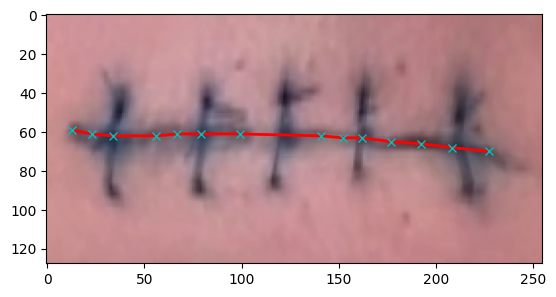

In [3]:
# INIT DATASET AND AUGMENTATIONS

# blur transforms 
transform_blur = A.Compose([
    A.OneOf([
    A.AdvancedBlur(p=0.8),
    A.Blur(p=0.8), 
    A.GaussianBlur(p=0.8),
    A.MedianBlur(p=0.8),
    A.MotionBlur(p=0.8)
  ], p=0.5) 
], keypoint_params=A.KeypointParams(format='xy'))
# spatial transforms
# TODO: add vertical flip ... requires flipping the order of points as well ... separate transform 
# TODO: handle when keypoints outside of img probably condition on len(keypoinst) when forward passing
transform_geom = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
      # TODO: when doing rotation some point easily gets out of picture
      A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=10, p=0.9),
      A.PiecewiseAffine(scale=(0.015, 0.025), p=0.9),
      A.Perspective(scale=(0.01, 0.03), p=0.9)  
    ], p=0.8)
], keypoint_params=A.KeypointParams(format='xy'))

transform_color = A.Compose([
    A.OneOf([
        A.ChannelDropout(p=0.8),
        A.ColorJitter(p=0.8),
        A.HueSaturationValue(p=0.8),
        A.RGBShift(p=0.8),
        A.RandomBrightnessContrast(p=0.8)
    ], p=0.5)
])
transform = A.Compose([transform_geom, transform_color, transform_blur])


train_dataset = ZdoDataset(data_train_p, normalize=True, transform=transform, incision_points=NUM_POINTS)
val_dataset = ZdoDataset(data_valid_p, normalize=True, transform=transform, incision_points=NUM_POINTS)


im, points = val_dataset.__getitem__(10)
visualize(im, points, unnormalize=True)

epoch: 0
train-epoch 0 loss: 0.00786302842456719 time: 5.80s
val-epoch 0 loss: 0.020420981198549272 time: 6.50s
epoch: 1
train-epoch 1 loss: 0.0065133553640595795 time: 5.70s
val-epoch 1 loss: 0.017820852249860762 time: 7.26s
epoch: 2
train-epoch 2 loss: 0.006496780391397147 time: 6.87s
val-epoch 2 loss: 0.01705424189567566 time: 8.62s
epoch: 3
train-epoch 3 loss: 0.005605352978254187 time: 6.56s
val-epoch 3 loss: 0.01759987324476242 time: 7.53s
epoch: 4
train-epoch 4 loss: 0.005695087257130393 time: 5.59s
val-epoch 4 loss: 0.016113622486591338 time: 7.63s
epoch: 5
train-epoch 5 loss: 0.0051849402230361415 time: 7.11s
val-epoch 5 loss: 0.015981826186180114 time: 8.97s
epoch: 6
train-epoch 6 loss: 0.004983991127589653 time: 6.17s
val-epoch 6 loss: 0.01716737300157547 time: 7.82s
epoch: 7
train-epoch 7 loss: 0.004404076535640092 time: 6.03s
val-epoch 7 loss: 0.01436130478978157 time: 7.91s
epoch: 8
train-epoch 8 loss: 0.004129854512625727 time: 5.28s
val-epoch 8 loss: 0.01676297932863235

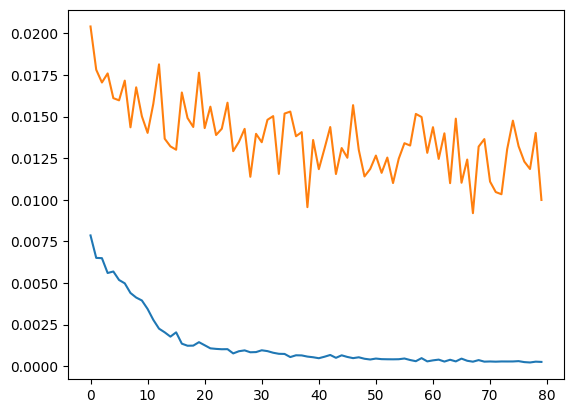

In [4]:
# setup dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloder = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=2)


# TRAIN!
def train(net, dataloaders, optimizer, criterion, num_epoch, device, validation=True, freq_print=10):
    net = net.to(device)
    loss_hist = np.ones((num_epoch,2))*np.inf
    for epoch in range(num_epoch):
        time_start = time.time()
        print(f"epoch: {epoch}")
        for loader_idx, phase in enumerate(dataloaders):
            if phase == 'train':
                net.train()
            else:
                if not validation:
                    break
                net.eval()

            loader = dataloaders[phase]
            running_loss = 0.0
            epoch_loss = 0.0
            # one batch
            for i, d in enumerate(loader, 0):
                inputs, points = d
                points = points.flatten(start_dim=1) # as output of the linear layer

                # print(f"points: {points.shape}")

                inputs, points = inputs.to(device), points.to(device)
                
                #zero the grad!
                optimizer.zero_grad()

                out = net(inputs)

                # the stuff
                loss = criterion(out, points)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
         
                # statistics
                running_loss += loss.item()
                epoch_loss += loss.item()

                if i % freq_print == (freq_print-1): 
                    print(f'{phase}: [{epoch + 1}, {i + 1:5d}] loss: {running_loss / freq_print:.3f}')
                    running_loss = 0.0 

            # normalize metrics by the size of data
            epoch_loss /= len(dataloaders[phase].dataset)
            loss_hist[epoch,loader_idx] = epoch_loss
            epoch_time = time.time() - time_start
            print(f"{phase}-epoch {epoch} loss: {epoch_loss} time: {epoch_time:.2f}s")
            
    print("training finished")
    plt.plot(loss_hist)
    
    return loss_hist

# train setup
dataloaders={'train': train_dataloader, 'val':val_dataloder}
num_epoch = 80
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
optimeizer = optim.AdamW(model.parameters())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss = nn.MSELoss()

loss_hist = train(model, dataloaders, optimizer, loss, num_epoch, device)

<Figure size 640x480 with 0 Axes>

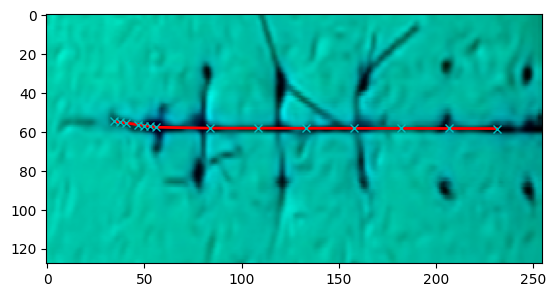

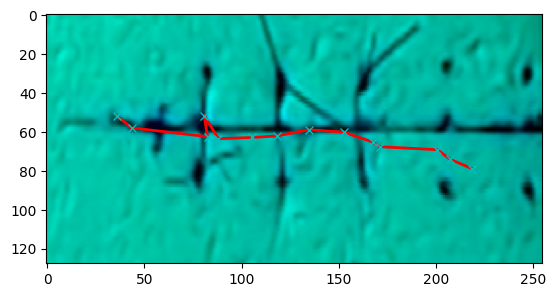

<Figure size 640x480 with 0 Axes>

In [87]:
# val_dataset = ZdoDataset(data_valid_p, normalize=True, transform=transform, incision_points=2)
im, points = val_dataset.__getitem__(7)
visualize(im, points, unnormalize=True)

# prediction:
model.eval()
im2 = (im.unsqueeze(0)).to(device)
points_pred = model(im2)
points_pred = points_pred.reshape([NUM_POINTS,2]).detach().cpu()
visualize(im, points_pred, unnormalize=True)
plt.figure()